In [2]:
import findspark
findspark.init()

In [5]:
import pyspark as spark
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.linalg import Vectors

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('yarn').appName('myapp').getOrCreate()
sc = spark.sparkContext

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer

training = spark.createDataFrame([
    (0,'a b c d e spark',1.0),
    (1,'b d',0.0),
    (2,'spark f g h',1.0),
    (3,'hadoop mapreduce',0.0)
],['id','text','label'])

In [7]:
from pyspark.ml.feature import Tokenizer

sentenceDataFrame = spark.createDataFrame([
    (0,'hi i heard about spark'),
    (1,'I wish java could use case classes')
],['id','sentence'])



In [8]:
tokenizer = Tokenizer(inputCol='sentence',outputCol='words')
tokenized = tokenizer.transform(sentenceDataFrame)

In [10]:
tokenized.show()

+---+--------------------+--------------------+
| id|            sentence|               words|
+---+--------------------+--------------------+
|  0|hi i heard about ...|[hi, i, heard, ab...|
|  1|I wish java could...|[i, wish, java, c...|
+---+--------------------+--------------------+



In [13]:
df= spark.createDataFrame([
    (0,'a b c'.split(' ')),
    (1,'a b b c a'.split(' '))]
,['id','words'])

cv = CountVectorizer(inputCol='words',outputCol='features')

In [14]:
model = cv.fit(df)
result = model.transform(df)
result.show(truncate=False)

+---+---------------+-------------------------+
|id |words          |features                 |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+



In [15]:
tokenizer = Tokenizer(inputCol='text',output='words')
tokenized = tokenizer.transform(training)

TypeError: __init__() got an unexpected keyword argument 'output'

In [17]:
tokenizer = Tokenizer(inputCol='text',outputCol='words')
cv = CountVectorizer(inputCol=tokenizer.getOutputCol(),
                    outputCol='features')

In [20]:
test = spark.createDataFrame([
    (4,'spark i j k'),
    (5,'l m n'),
    (6,'spark hadoop spark'),
    (7,'apache hadoop')
],['id','text'])
cv = CountVectorizer(inputCol='text',outputCol='features')
model = cv.fit(test)
prediction = model.transform(test)
prediction.show(truncate=False)

IllegalArgumentException: 'requirement failed: Column text must be of type equal to one of the following types: [array<string>, array<string>] but was actually of type string.'

In [22]:
from pyspark.ml.regression import LinearRegression

df = spark.read.option('header','true')\
            .option('nullValue','?')\
            .option('inferSchema','true')\
            .csv('s3://ssds2/Housing.csv')

df.show()

+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  6|66000|   4160|       3|      1|      1|     yes|    yes|     yes|   no|  yes|       0|      no|
|  7|66000|   3880|       3|      2|      2|     yes|     no|     yes|   no|   no|       2|

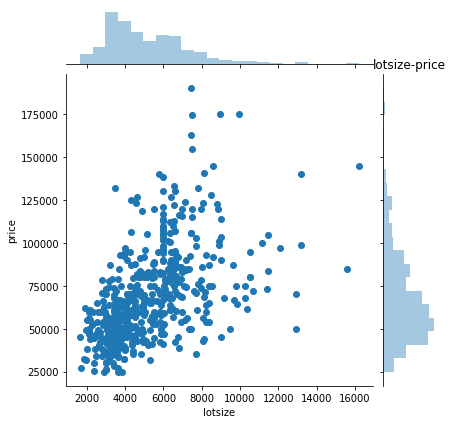

In [24]:
import pandas as pd
import matplotlib as mpl
import matplotlib,pylab as plt
import seaborn as sns
df_pd = df.toPandas()

df_pd['price'] = pd.to_numeric(df_pd['price'])
sns.jointplot(x='lotsize',y='price',data=df_pd)
plt.title('lotsize-price')
plt.show()

In [28]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

training = VectorAssembler(inputCols=['lotsize'],outputCol='features')\
            .transform(df)


In [30]:
lr=LinearRegression(featuresCol='features',labelCol='price',maxIter=100,regParam=0.3,elasticNetParam=0.8)
lrModel = lr.fit(training)

In [31]:
lr=LinearRegression(featuresCol='features',labelCol='price',maxIter=100,regParam=0.3,elasticNetParam=0.8)
lrModel = lr.fit(training)
print('coefficients : %s'%str(lrModel.coefficients))
print('intercept: %s'%(lrModel.intercept))
trainingSummary = lrModel.summary
print('numIteractions:%d'%trainingSummary.totalIterations)
print('ObjectiveHistory:%s'%str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print('RMSE:%f'%(trainingSummary.rootMeanSquaredError))
print('r2:%f'%trainingSummary.r2)


coefficients : [6.598641954233914]
intercept: 34136.838618692855
numIteractions:5


In [32]:
print('ObjectiveHistory:%s'%str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print('RMSE:%f'%(trainingSummary.rootMeanSquaredError))
print('r2:%f'%trainingSummary.r2)


ObjectiveHistory:[0.5000000000000004, 0.44925567084835316, 0.3796638988719788, 0.362265955877885, 0.35646664154652086]
+-------------------+
|          residuals|
+-------------------+
|-30738.894050961244|
| -22031.40643562851|
| -4828.682998648626|
|-17517.807614348392|
|-15104.201447620551|
|  4412.810851694063|
|   6260.43059887956|
|  7412.810851694063|
| 17989.680000984357|
| 18070.630633020628|
|  8352.939310822956|
|-23432.764481394595|
|-18354.529940890512|
|-17140.927446886526|
| -20891.94965393495|
|-17253.513242927875|
|-15412.357067664765|
|-27699.776780709217|
|-11902.153360799857|
| -15439.02544826924|
+-------------------+
only showing top 20 rows



In [33]:
print('RMSE:%f'%(trainingSummary.rootMeanSquaredError))
print('r2:%f'%trainingSummary.r2)


RMSE:22525.681840
r2:0.287077


In [34]:
df_pd.columns

Index(['_c0', 'price', 'lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway',
       'recroom', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea'],
      dtype='object')

In [36]:
type(df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 13 columns):
_c0         546 non-null int32
price       546 non-null float64
lotsize     546 non-null int32
bedrooms    546 non-null int32
bathrms     546 non-null int32
stories     546 non-null int32
driveway    546 non-null object
recroom     546 non-null object
fullbase    546 non-null object
gashw       546 non-null object
airco       546 non-null object
garagepl    546 non-null int32
prefarea    546 non-null object
dtypes: float64(1), int32(6), object(6)
memory usage: 42.7+ KB


NoneType

In [38]:
cols = ['driveway','recroom','fullbase','gashw','airco','prefarea']
for c in cols:
    print(c)
    print(df_pd[c].value_counts())
    

driveway
yes    469
no      77
Name: driveway, dtype: int64
recroom
no     449
yes     97
Name: recroom, dtype: int64
fullbase
no     355
yes    191
Name: fullbase, dtype: int64
gashw
no     521
yes     25
Name: gashw, dtype: int64
airco
no     373
yes    173
Name: airco, dtype: int64
prefarea
no     418
yes    128
Name: prefarea, dtype: int64


Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LinearRegression' object has no attribute '_java_obj'


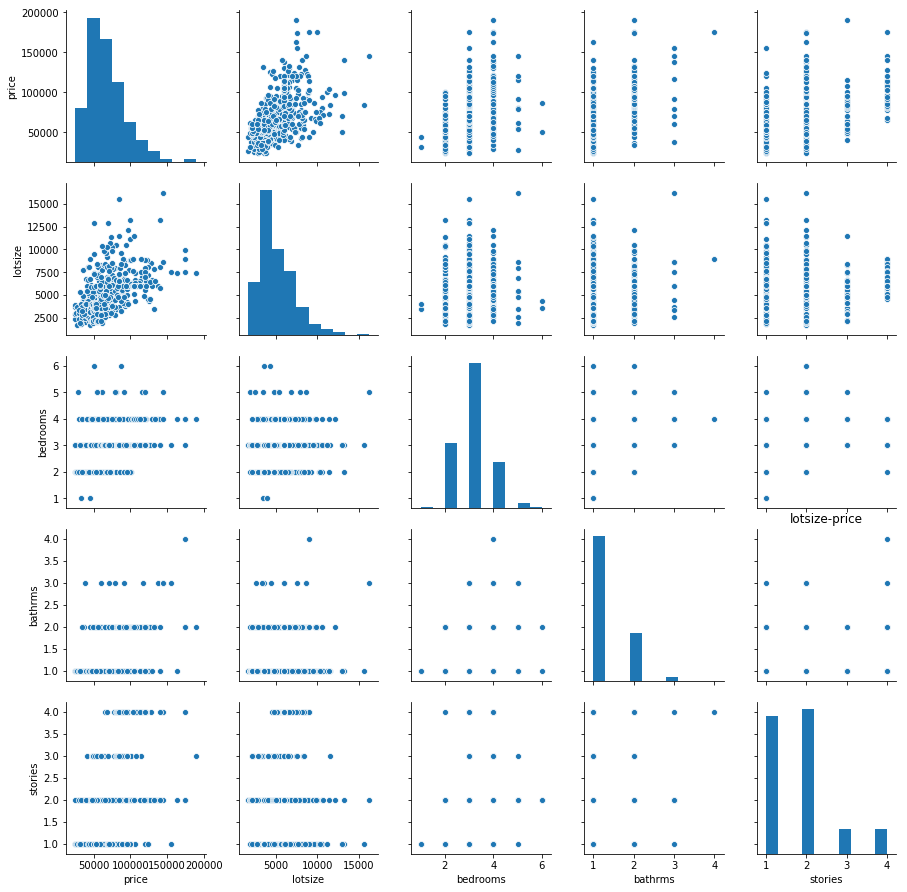

In [40]:
sns.pairplot(df_pd[['price','lotsize','bedrooms','bathrms','stories']])
plt.title('lotsize-price')
plt.show()

In [50]:
training2 = VectorAssembler(inputCols=['lotsize','bedrooms','bathrms','stories'],outputCol='features').transform(df)

In [47]:
type(training2)

pyspark.sql.dataframe.DataFrame

In [48]:
training2.show()

+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------------------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|            features|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------------------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|[42000.0,5850.0,3...|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[38500.0,4000.0,2...|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[49500.0,3060.0,3...|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|[60500.0,6650.0,3...|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[61000.0,6360.0,2...|
|  6|66000|   4160|     

In [51]:
lrModel2 = lr.fit(training2)

print('coefficients : %s'%str(lrModel2.coefficients))
print('intercept: %s'%(lrModel2.intercept))

training2Summary = lrModel2.summary
print('numIteractions:%d'%training2Summary.totalIterations)
print('RMSE:%f'%(training2Summary.rootMeanSquaredError))
print('r2:%f'%training2Summary.r2)



coefficients : [5.429075478282878,2824.4761006140557,17104.914152966165,7634.720097894929]
intercept: -4007.98137770452
numIteractions:14
RMSE:18181.402782
r2:0.535547


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.pipeline import Pipeline

pipeline = Pipeline(stages=[
    
])
pipeline.fit(df)

In [56]:
from pyspark.sql.functions import col
import pyspark.sql.functions as sf

df = df.withColumn('joined_column', 
                    sf.concat(sf.col('driveway'),sf.lit('_'), sf.col('recroom')))
df.show()


+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+----+-------------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea| sum|joined_column|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+----+-------------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|null|       yes_no|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|null|       yes_no|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|null|       yes_no|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|null|      yes_yes|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|null|       yes_no|
|  6|66000|   4160|       3|      1|    

In [58]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 13 columns):
_c0         546 non-null int32
price       546 non-null float64
lotsize     546 non-null int32
bedrooms    546 non-null int32
bathrms     546 non-null int32
stories     546 non-null int32
driveway    546 non-null object
recroom     546 non-null object
fullbase    546 non-null object
gashw       546 non-null object
airco       546 non-null object
garagepl    546 non-null int32
prefarea    546 non-null object
dtypes: float64(1), int32(6), object(6)
memory usage: 42.7+ KB


In [78]:
from pyspark.ml.regression import LinearRegression
from itertools import combinations

catecols = ["lotsize","bedrooms","bathrms","stories","driveway","recroom","fullbase","gashw","airco","garagepl","prefarea"]    

def combinationcol(lst,i):
    
    return list(combinations(lst,i))

def 

df = spark.read.option('header','true')\
            .option('nullValue','?')\
            .option('inferSchema','true')\
            .csv('s3://ssds2/Housing.csv')


import pyspark.sql.functions as F
from pyspark.sql.types import StringType

concat_udf = F.udf(lambda cols: "".join([x if x is not None else "*" for x in cols]), StringType())
df2 = df.withColumn("sum", concat_udf(F.array("driveway", "recroom","fullbase","gashw","airco")))

from pyspark.ml.feature import StringIndexer
from pyspark.ml.pipeline import Pipeline

stringindexer = StringIndexer(inputCol=)

pipeline = Pipeline(stages=[
    
])
pipeline.fit(df)

SyntaxError: invalid syntax (<ipython-input-78-8368119effd1>, line 10)

In [65]:
df.select(df['price'].alias,1 if df['driveway']=='yes' else 0).show()



ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

In [84]:
import numpy as np
df_pd2 = df_pd.copy()

catecols = ["driveway", "recroom","fullbase","gashw","airco",'prefarea']   
for c in catecols:
    df_pd2[c]= np.where(df_pd2[c]=='yes',int(1),int(0))
spark.createDataFrame(df_pd2).show()

+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|_c0|  price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|
+---+-------+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|  1|42000.0|   5850|       3|      1|      2|       1|      0|       1|    0|    0|       1|       0|
|  2|38500.0|   4000|       2|      1|      1|       1|      0|       0|    0|    0|       0|       0|
|  3|49500.0|   3060|       3|      1|      1|       1|      0|       0|    0|    0|       0|       0|
|  4|60500.0|   6650|       3|      1|      2|       1|      1|       0|    0|    0|       0|       0|
|  5|61000.0|   6360|       2|      1|      1|       1|      0|       0|    0|    0|       0|       0|
|  6|66000.0|   4160|       3|      1|      1|       1|      1|       1|    0|    1|       0|       0|
|  7|66000.0|   3880|       3|      2|      2|       1|      0|       1| 

In [95]:
df2 = spark.createDataFrame(df_pd2)
from pyspark.ml.regression import LinearRegression
from itertools import combinations

def modeltraining(cols):
    print(cols)
    training = VectorAssembler(inputCols=cols,outputCol='features').transform(df2)
    lr=LinearRegression(featuresCol='features',labelCol='price',maxIter=100,regParam=0.3,elasticNetParam=0.8)
    lrModel = lr.fit(training)
    #print('coefficients : %s'%str(lrModel.coefficients))
    #print('intercept: %s'%(lrModel.intercept))
    trainingSummary = lrModel.summary
    #print('numIteractions:%d'%trainingSummary.totalIterations)
    #print('ObjectiveHistory:%s'%str(trainingSummary.objectiveHistory))
    #trainingSummary.residuals.show()
    print('RMSE:%f'%(trainingSummary.rootMeanSquaredError))
    print('r2:%f'%trainingSummary.r2)  
    print('========================================')

def combinationcol(lst,i):    
    return list(combinations(lst,i))

catecols = ["lotsize","bedrooms","bathrms","stories","driveway","recroom","fullbase","gashw","airco","garagepl","prefarea"]
for i in range(12,0,-1):
    for j in (combinations(catecols,i)):
        modeltraining(j)








('lotsize',)
RMSE:22525.681840
r2:0.287077
('bedrooms',)
RMSE:24822.438261
r2:0.134284
('bathrms',)
RMSE:22840.677401
r2:0.266999
('stories',)
RMSE:24196.395066
r2:0.177401
('driveway',)
RMSE:26678.206724
r2:-0.000000
('recroom',)
RMSE:26678.206724
r2:-0.000000
('fullbase',)
RMSE:26678.206724
r2:-0.000000
('gashw',)
RMSE:26678.206724
r2:-0.000000
('airco',)
RMSE:26678.206724
r2:-0.000000
('garagepl',)
RMSE:24640.607304
r2:0.146920
('prefarea',)
RMSE:26678.206724
r2:-0.000000
('lotsize', 'bedrooms')
RMSE:21170.643131
r2:0.370269
('lotsize', 'bathrms')
RMSE:19528.226953
r2:0.464188
('lotsize', 'stories')
RMSE:20146.538241
r2:0.429721
('lotsize', 'driveway')
RMSE:22525.681840
r2:0.287077
('lotsize', 'recroom')
RMSE:22525.681840
r2:0.287077
('lotsize', 'fullbase')
RMSE:22525.681840
r2:0.287077
('lotsize', 'gashw')
RMSE:22525.681840
r2:0.287077
('lotsize', 'airco')
RMSE:22525.681840
r2:0.287077
('lotsize', 'garagepl')
RMSE:21834.281589
r2:0.330170
('lotsize', 'prefarea')
RMSE:22525.681840
r

KeyboardInterrupt: 

In [80]:
catecols = ["lotsize","bedrooms","bathrms","stories","driveway","recroom","fullbase","gashw","airco","garagepl","prefarea"]
for i in range(1,len(catecols)+1):
    print(list(combinations(catecols,i)))

[('lotsize',), ('bedrooms',), ('bathrms',), ('stories',), ('driveway',), ('recroom',), ('fullbase',), ('gashw',), ('airco',), ('garagepl',), ('prefarea',)]
[('lotsize', 'bedrooms'), ('lotsize', 'bathrms'), ('lotsize', 'stories'), ('lotsize', 'driveway'), ('lotsize', 'recroom'), ('lotsize', 'fullbase'), ('lotsize', 'gashw'), ('lotsize', 'airco'), ('lotsize', 'garagepl'), ('lotsize', 'prefarea'), ('bedrooms', 'bathrms'), ('bedrooms', 'stories'), ('bedrooms', 'driveway'), ('bedrooms', 'recroom'), ('bedrooms', 'fullbase'), ('bedrooms', 'gashw'), ('bedrooms', 'airco'), ('bedrooms', 'garagepl'), ('bedrooms', 'prefarea'), ('bathrms', 'stories'), ('bathrms', 'driveway'), ('bathrms', 'recroom'), ('bathrms', 'fullbase'), ('bathrms', 'gashw'), ('bathrms', 'airco'), ('bathrms', 'garagepl'), ('bathrms', 'prefarea'), ('stories', 'driveway'), ('stories', 'recroom'), ('stories', 'fullbase'), ('stories', 'gashw'), ('stories', 'airco'), ('stories', 'garagepl'), ('stories', 'prefarea'), ('driveway', 'rec

In [102]:
import numpy as np
df_pd2 = df_pd.copy()

catecols = ["driveway", "recroom","fullbase","gashw","airco",'prefarea']   
for c in catecols:
    df_pd2[c]= np.where(df_pd2[c]=='yes',int(1),int(0))
spark.createDataFrame(df_pd2).show()

df2 = spark.createDataFrame(df_pd2)
from pyspark.ml.regression import LinearRegression
from itertools import combinations
res = pd.DataFrame(columns=['com','r2','rmse'])
count = 0 
def modeltraining(cols):
    print(cols)
    training = VectorAssembler(inputCols=cols,outputCol='features').transform(df2)
    lr=LinearRegression(featuresCol='features',labelCol='price',maxIter=100,regParam=0.3,elasticNetParam=0.8)
    lrModel = lr.fit(training)
    #print('coefficients : %s'%str(lrModel.coefficients))
    #print('intercept: %s'%(lrModel.intercept))
    trainingSummary = lrModel.summary
    #print('numIteractions:%d'%trainingSummary.totalIterations)
    #print('ObjectiveHistory:%s'%str(trainingSummary.objectiveHistory))
    #trainingSummary.residuals.show()
    rmse = trainingSummary.rootMeanSquaredError
    r2 = trainingSummary.rootMeanSquaredError
    print('RMSE:%f'%(trainingSummary.rootMeanSquaredError))
    print('r2:%f'%trainingSummary.r2)  
    res[count] = (cols,r2,rmse)
    print('========================================')

def combinationcol(lst,i):    
    return list(combinations(lst,i))

catecols = ["lotsize","bedrooms","bathrms","stories","driveway","recroom","fullbase","gashw","airco","garagepl","prefarea"]
for i in range(12,-1,-1):
    for j in (combinations(catecols,i)):
        modeltraining(j)
    



('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea')
RMSE:17669.532003
r2:0.561331
('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'garagepl')
RMSE:17669.532003
r2:0.561331
('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'prefarea')
RMSE:18181.402782
r2:0.535547
('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom', 'fullbase', 'gashw', 'garagepl', 'prefarea')
RMSE:17669.532003
r2:0.561331
('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom', 'fullbase', 'airco', 'garagepl', 'prefarea')
RMSE:17669.532003
r2:0.561331
('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom', 'gashw', 'airco', 'garagepl', 'prefarea')
RMSE:17669.532003
r2:0.561331
('lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea')
RMSE:17669.532003
r2:0.5

KeyboardInterrupt: 

In [93]:
ll = list(map(lambda x : x[0],df2.dtypes))
ll..remove('_c0').remove('price')

AttributeError: 'NoneType' object has no attribute 'remove'

In [100]:
res = pd.DataFrame(columns=['com','r2','rmse'])

In [98]:
res.loc[1]=(1,1,1)

In [99]:
res

,com,r2,rmse
1,1,1,1


In [103]:
res

,com,r2,rmse,0
0,NaN,NaN,NaN,"(lotsize, stories, garagepl, prefarea)"
1,NaN,NaN,NaN,19412.5
2,NaN,NaN,NaN,19412.5
